# 01. Kirchberger Holz land use

*16 Aug 2020*

Check conversion of a large MultiPolygon that has failed in the past

In [1]:
%load_ext autoreload
%autoreload 2

import osmnx as ox # using fork `New geometries module - Work In Progress`
ox.utils.config(use_cache=True, log_console=True)

import matplotlib.pyplot as plt

import geopandas as gpd
import pandas as pd
pd.set_option('display.max_columns', None)

## Kirchberger Holz
***https://www.openstreetmap.org/search?query=Kirchberger%20Holz#map=11/48.1345/10.0037***


In [2]:
point=(48,10)
dist=(10000)
tag='landuse'

### Comparing time of `footprints`, `pois` and `geometries`

All run after query results had been cached

In [3]:
%%time
footprints_gdf = ox.footprints_from_point(point=point, dist=dist,footprint_type=tag)

CPU times: user 642 ms, sys: 19.6 ms, total: 661 ms
Wall time: 661 ms


In [4]:
%%time
pois_gdf = ox.pois_from_point(point=point, tags={tag:True}, dist=dist)

/home/nick/anaconda3/envs/osmnx-dev/lib/python3.6/site-packages/pandas/core/internals/blocks.py:844: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  arr_value = np.array(value)


CPU times: user 3.55 s, sys: 31.7 ms, total: 3.58 s
Wall time: 3.58 s


In [5]:
%%time
geometries_gdf = ox.gdf_from_point(point, tags={tag:True}, dist=dist)

CPU times: user 1.12 s, sys: 32 ms, total: 1.15 s
Wall time: 1.15 s


`footprints`
- queries based on a polygon
- doesn't do any spatial filtering at the end (i.e. retains all polygonal geometries returned by Overpass API)

`pois`
- queries based on a bounding box
- filters results at the end with `gdf_proj.centroid.within(poly_proj)`
- slower as it doesn't use any spatial indexing

`geometries`
- queries based on a polygon
- filters results at the end with `utils_geo._intersect_index_quadrats(gdf, polygon)`
- spatial indexing significantly faster
- slower than `footprints`

### Comparison of results

- number and type of geometries created
- overlay of geometries

pois_gdf.shape (1995, 81)
pois_gdf geometry types: ['Point' 'Polygon' 'MultiPolygon']
footprints_gdf.shape (1831, 60)
footprints_gdf geometry types: ['Polygon' 'MultiPolygon']
geometries_gdf.shape (1815, 63)
geometries_gdf geometry types: ['Polygon' 'MultiPolygon']


<AxesSubplot:>

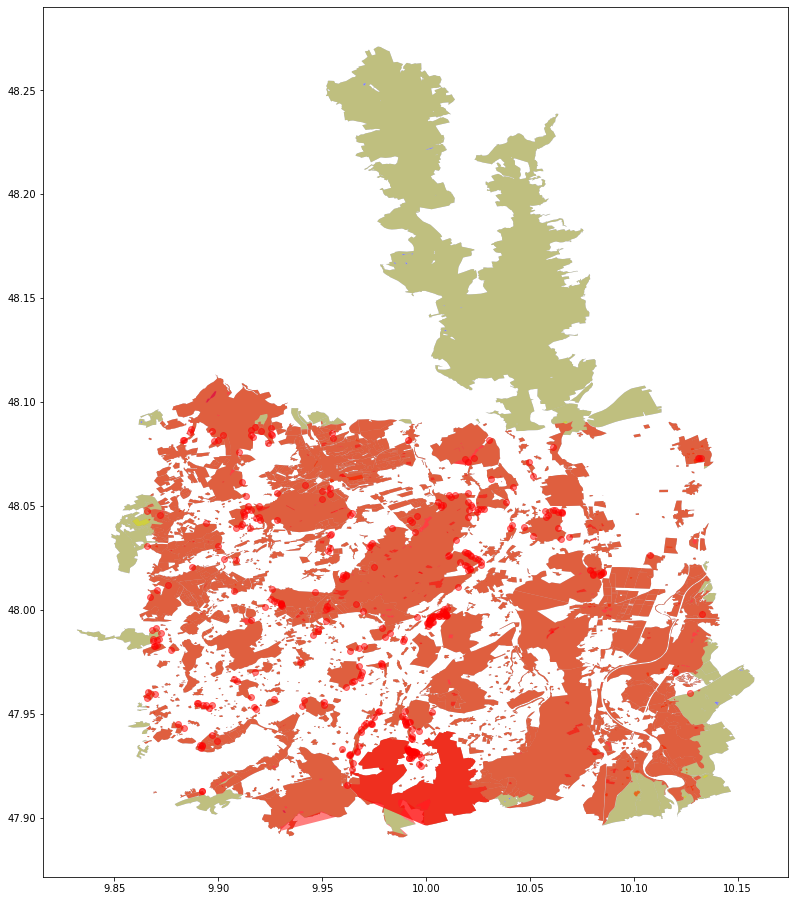

In [6]:
print("pois_gdf.shape", pois_gdf.shape)
print("pois_gdf geometry types:", pois_gdf['geometry'].geom_type.unique())
print("footprints_gdf.shape", footprints_gdf.shape)
print("footprints_gdf geometry types:", footprints_gdf['geometry'].geom_type.unique())
print("geometries_gdf.shape", geometries_gdf.shape)
print("geometries_gdf geometry types:", geometries_gdf['geometry'].geom_type.unique())


fig,ax = plt.subplots(figsize=(16,16))
footprints_gdf.plot(ax=ax, alpha=0.5, color='blue')
geometries_gdf.plot(ax=ax, alpha=0.5, color='yellow')
pois_gdf.plot(ax=ax, alpha=0.5, color='red')

#### Notes

- `pois` doesn't assemble chains of open ways into larger polygons
- it simply closes each open way and tries to convert it to a polygon (see the straight edges in the image)
- results from `footprints` and `geometries` are largely identical

#### Why does the `pois` module return more geometries, including some points?

- The `pois` module only filters by *tag* at the query stage i.e. in the request to the Overpass API.
- It converts every node it receives with any tags to a Point and tries to convert every way/relation to a Polygon/MultiPolygon

This means that points that are returned as part of `landuse` polygons that have any kind of tag (e.g. `created_by:JOSM`) are returned as part of the final geodataframe even though they are not directly tagged with `landuse`. See below:

,osmid,geometry,created_by,element_type,name,traffic_sign,leisure,sport,crossing:island,highway,FIXME,emergency,amenity,barrier,entrance,access,bicycle,foot,direction,TMC:cid_58:tabcd_1:Class,TMC:cid_58:tabcd_1:LCLversion,TMC:cid_58:tabcd_1:LocationCode,TMC:cid_58:tabcd_1:NextLocationCode,TMC:cid_58:tabcd_1:PrevLocationCode,nodes,natural,landuse,ele,water,old_name,source,source:outline,denomination,religion,motor_vehicle,addr:city,addr:country,addr:housenumber,addr:postcode,addr:street,man_made,operator,product,website,place,leaf_type,industrial,power,substation,voltage,opening_hours,recycling:hardcore,recycling:scrap_metal,recycling:waste,recycling_type,trees,description,plant:source,waterway,brand,shop,description:de,leaf_cycle,phone,toilets:wheelchair,tourism,wheelchair,wheelchair:description,basin,wetland,reservoir_type,is_in,community:gender,golf,crop,landcover,type,ways,boundary,note,construction
34663189,34663189,POINT (9.88694 48.08685),JOSM,node,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
34663190,34663190,POINT (9.88641 48.08535),JOSM,node,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
34663193,34663193,POINT (9.88331 48.08170),JOSM,node,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
34663194,34663194,POINT (9.88314 48.08175),JOSM,node,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
34663219,34663219,POINT (9.89678 48.08621),JOSM,node,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23708853,23708853,"POLYGON ((9.96709 47.91001, 9.96703 47.91024, ...",NaN,way,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[2079324227, 4663558590, 4663558591, 466355858...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
171504816,171504816,"POLYGON ((9.97969 47.92341, 9.97965 47.92315, ...",NaN,way,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[1825234877, 1825234872, 1825234867, 320887832...",water,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
171504818,171504818,"POLYGON ((9.96636 47.92092, 9.96709 47.92063, ...",NaN,way

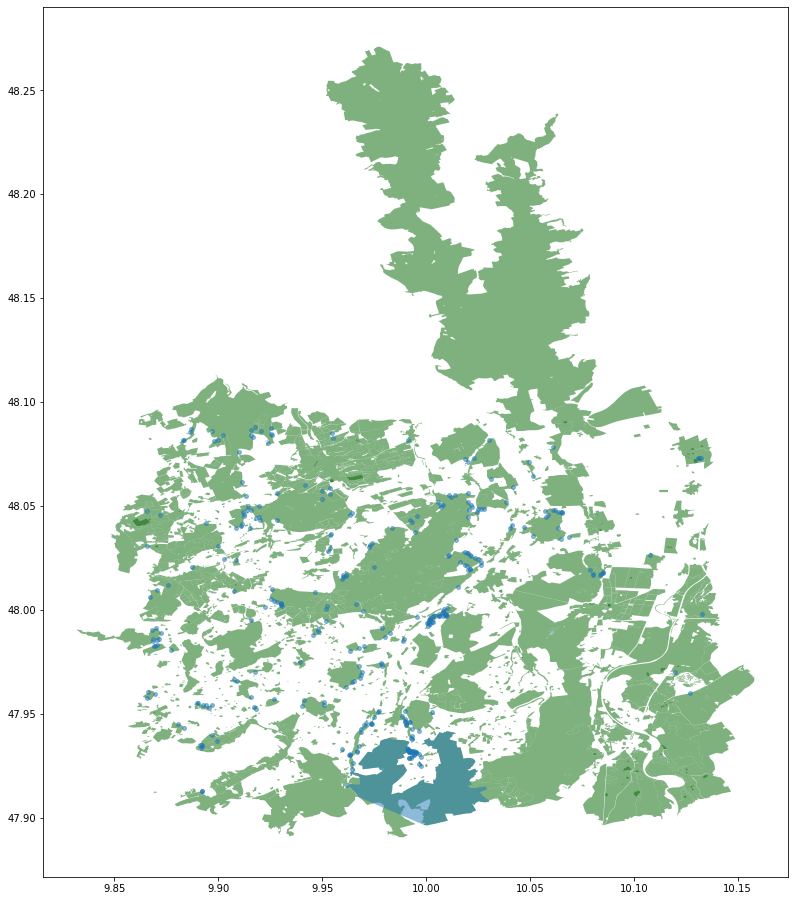

In [7]:
# plot results from `geometries` in green
ax = geometries_gdf.plot(figsize=(16,16), color='darkgreen', alpha=0.5)
# plot results from `pois` whose id is not in the results from `geometries` in blue
pois_gdf[~pois_gdf['osmid'].isin(geometries_gdf['osmid'])].plot(ax=ax, markersize=15, alpha=0.5)

# show these records
pois_gdf[~pois_gdf['osmid'].isin(geometries_gdf['osmid'])]